#**Курсовая работа по модулю Обработка естественного языка (NLP). Повышенный уровень**

##**Цель курсовой работы**

**Тема работы: Реализация модели нейронного машинного перевода на корпусе с ненецким языком.**

Задачи: Сбор текстовых данных на ненецком языке, реализация перевода на нескольких языках с целью улучшения способностей нейросети, предварительная обработка сформированного датасета, проведение мультиязычного обучения нейросети для задачи машинного перевода и последующее резюме результатов работы с помощью метрик оценки машинного перевода (BLEU, COMET).

##**Сбор данных**

Для составления корпуса использовался источник: [сборник](https://libraries-yanao.ru/upload/iblock/289/Jangasova.pdf) ненецких сказок Янгасовой Н.М. 2007 года (Ненецие” лаханако”).

Для сбора данных из печатного сборника ненецких сказок (Ненецие” лаханако”) было применено распознавание и пост-редактирование ненецкого и русского текста в OCR-редакторе ABBYY FineReader PDF 15. Затем эти данные были скопированы в txt-файл, где были обработаны и преобразованы различные символы для единого стиля документа (такие как гортанный смычный звук, тире, цифры, которые обозначали в сборнике ссылки, и другие символы, которые могли распознаться некорректно).

Таким образом, в файле nenets_tales_yangasova.txt было определено 4 столбца: название сказки на ненецком языке (title_nen) и русском (title_rus), содержание сказки на ненецком (tale_nen) и русском (tale_rus).

## **Формирование параллельного корпуса**

In [ ]:
import pandas as pd
import numpy as np
import csv
import re

In [ ]:
import nltk

**Описание используемого набора данных**


nenets_tales_yangasova.txt, 32 записи, 4 признака: title_nen, title_rus,	tale_nen и tale_rus, что соответственно содержит название сказок на ненецком языке и русском и их содержание на ненецком и русском.

In [ ]:
txt = 'nenets_tales_yangasova.txt'
csv_file = 'nenets_tales_yangasova.csv'

with open(txt, 'r', encoding='utf-8') as f_txt, open(csv_file, 'w', encoding='utf-8', newline='') as f_csv:
    reader = f_txt.readlines()

    # cоздание объекта writer для записи в csv файл
    writer = csv.writer(f_csv, delimiter=',')
    writer.writerow(['title_nen', 'title_rus', 'tale_nen', 'tale_rus'])

    # определение и запись для каждой строки
    for i in range(0, len(reader), 4):
        title_nen = reader[i].strip()  # название сказки на ненецком языке
        tale_nen = reader[i+1].strip()  # текст сказки на ненецком языке
        title_rus = reader[i+2].strip()  # название сказки на русском языке
        tale_rus = reader[i+3].strip()  # текст сказки на русском языке
        writer.writerow([title_nen, title_rus, tale_nen, tale_rus])

### **Набор данных с названиями сказок**

In [ ]:
df = pd.read_csv('nenets_tales_yangasova.csv', sep=',')
title_df = df[['title_nen', 'title_rus']].copy()

# Добавляем столбец с нумерацией перед всеми столбцами
df.insert(0, 'num_index', range(len(df)))

df

num_index             title_nen                 title_rus  \
0           0           Хаби вэсако              Старик-ханты   
1           1             Хабей’ не             Женщина-ханты   
2           2  Вэсакохо’, пухуцяха’          Старик и старуха   
3           3             Вано Сава                 Вано Сава   
4           4      Маңгабада вэсако             Бедный старик   
5           5             Туңгэвыхы                 Тунгэвыхы   
6           6      Маңгабада вэсако             Бедный старик   
7           7           Хаби вэсако              Старик-ханты   
8           8      Сэдко’ няхар” ню            Три сына Сэдко   
9           9       Сидя Сэрм’ Мэта            Сидя Сэрм Мэта   
10         10    Есьтана поп вэсако        Старик-поп Есьтана   
11         11              Василеця                  Василеця   
12         12               Сидя не               Две женщины   
13         13       Няхар” ненэй не      Три ненецкие женщины   
14         14       Пухуця’ ноб” ню  Единственный сын старухи   
15         15           Луца вэсако            Старик-русский   
16         16      Вынахалуй хабиця          Исхудавший ханты   
17         17             Неле”мяко                  Нелемяко   
18         18         Мэбета ханена           Мужчина-охотник   
19         19         Нядэна хасава    Оседло живущий мужчина   
20         20      Писяко’ вомдё”ма          Мышкины проделки   
21         21                Писяко                     Мышка   
22         22  Писякохо’, хорекохо’             Мышка и бычок   
23         23             Халэв’ сё               Песня чайки   
24         24          Харңэ’ не ню               Дочь ворона   
25         25   Шаньгы” ёмзя’ вакця       Снегопад из шанежек   
26         26           Маңгабадако                    Бедняк   
27         27    Ёхоборта ңацекэхэ’         Потерявшиеся дети   
28         28          Сидя тосанда   Два охотника на соболей   
29         29      Купец’ няхар” ню            Три сына купца   
30         30        Вэсако’ табеко             Завет старика   
31         31              Лаханако                    Сказка   

                                             tale_nen  \
0   Хаби вэсако Неро яхаконда ниня иле. Ңэрёй халя...   
1   Неро яхаконда хэвахана хабицяр илевы. сядэцяда...   
2   Я’ мидахана вэсакохо’, пухуцяха’ илевэхэ’. Нюд...   
3   Параңода’ харад’ вэкана, няби вэта левсей хард...   
4   Ңавнанда хунананда маңгабада вэсако танявы. Пы...   
5   Ся”ны ңэбта ңод” ңоб” не илевы. Няхар” хасава ...   
6   Моңгата яха’ тир’ ниня маңгабада вэсако пухуця...   
7   Вэсако луца пухуцянда ня’ илевэхэ’. Нюди таняв...   
8   Ңавна хунанда, я мидахана, няхар” не пирибтя х...   
9   Я’ хой ниня ю” мя”. Ңэсындо’ ервота Сидя Сэрм’...   
10  Параңода’ харад’ няби вэкана, маха левсей хард...   
11  Василеця сэвата ңадиво”махад пили” хонёсеты. М...   
12  Сидя не илевэхэ’. Ханахавади’ — ю” вандако. Сэ...   
13  Няхар” ненэй не ядавы”. Ядавандо’ сер’ ңарка н...   
14  Пухуцяко”я цоб” нюнда ня’ сянанд хунанд нэбта ...   
15  Луца вэсакохо’ пухуцянда ня’ ян’ сидярихи’. Мя...   
16  Сяхаңгав’ ңавнанда вынахалуй хабиця илевы. Вын...   
17  Неро яхако’ тир’ ниня пухуця нюнда ня’ таня ил...   
18  Ңавна хунанда, илева’ тяхана, ңарка саля яв’ я...   
19  Ңавнанда хунананда ңоб” яха хэвахана ңоб” хаса...   
20  Писяко хаерад’ няңы яля’ няюв’ сядоць пидянда ...   
21  Яв’ салякохона писяко’ ваңготада ңэвы. Писякор...   
22  Писякор ңэванда серри етри яда. Тарем’ миндяха...   
23  Яв’ марахана юрмян” халэв” морена”. Тарем’ сыр...   
24  Ся”ны ңэбта ңод” харңэ вэсако илевы. Не нюда т...   
25  Параңода’ хард’ вэкана вэсакохо’ пухуцяха’ иле...   
26  Параңода’ харад’ вэкана маңгабада лучеңг пухуц...   
27  Ся”ны ңэбта ңод” ңацекэхэ’ сянакованди’ сер’ ё...   
28  Сидя тосандаха’, сидя пебясаха’ илевэхэ’. Сидя...   
29  Параңгода’ харад’ вэкана цоб” купец параңгода’...   
30  Ся”ня ңэбта ңод”, я’ сяр’ ниня ңопой вэсако ил...   
31  Вэсакохо’, пухуцяха’ илевэхэ’.

In [ ]:
df = df.drop(['title_nen', 'title_rus'], axis=1)

### **Набор данных с содержанием сказок**

In [ ]:
nltk.download('punkt')

# Функция для подсчета количества предложений в тексте
def count_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

df['nn_sentence_count'] = df['tale_nen'].apply(count_sentences)
df['ru_sentence_count'] = df['tale_rus'].apply(count_sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Разделение абзацев на предложения
def split_into_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return sentences

df_expanded_1 = pd.DataFrame(columns=['nn', 'ru'])

# Прохождение по строкам и разделение абзацев при совпадении количества
# предложений
for idx, row in df.iterrows():
    # Проверяем, что индекс не в исключенном списке
    if idx in [17, 24, 31]: # у 18, 22, 25, 27 так же одинаковое кол-во
        # предложений, но они не соответствуют
        if row['nn_sentence_count'] == row['ru_sentence_count']:
            nn_sentences = split_into_sentences(row['tale_nen'])
            ru_sentences = split_into_sentences(row['tale_rus'])
            df_expanded_1 = pd.concat([df_expanded_1, pd.DataFrame({'nn': nn_sentences, 'ru': ru_sentences})], ignore_index=True)

In [ ]:
# Разделенные сказки с соответствующим кол-вом предложений и примерным объемом слов
df_expanded_1

nn  \
0    Неро яхако’ тир’ ниня пухуця нюнда ня’ таня ил...   
1                            Нюда Неле”мяком’ нюбе”ңа.   
2                     Неро яхаконди’ халям’ хадабихи’.   
3    Ся”ны’ ңэбта ңод” Неле”мяконд небя ма”нив’: — ...   
4                          Ңоб” ямб по’ таня илеңаха’.   
..                                                 ...   
103  Вэсакода ңани’ ма: — Вэнекоми мань хар”ни ховэ...   
104                     Пыдар вэнекодар пюванзь хань”.   
105  Ңамгэ пирка”на хибяхава ханяхавад мамонда: — В...   
106                       Вэнекори’ ңобзер’ вэнекори’.   
107                                         Та’ малда.   

                                                    ru  
0    На берегу тальниковой речки жила старуха со св...  
1                           Ребенка ее звали Нелемяко.  
2                 Они ловят рыбу на тальниковой речке.  
3    Однажды мать Нелемяко говорит: — Не ходи в вер...  
4                           Так живут один долгий год.  
..                                                 ...  
103   Старик снова говорит: — Ведь я же нашел собачку.  
104                  Ты иди и сама найди себе собачку.  
105  Через некоторое время слышат, как кто-то говор...  
106                          Собачка будет ваша общая.  
107                                              Конец  

[108 rows x 2 columns]

"Неле”мяко", "Харңэ’ не ню" и "Лаханако" разделились на предложения в соответствии с количеством предложений в содержании сказок и примерным объемом слов в предложениях (ручная проверка).


Следует разделить оставшиеся записи в датасете.

In [ ]:
# Удаление разделенных записей
df = df.drop([17, 24, 31], axis=0)

In [ ]:
# Регулярное выражение для разбиения текста на предложения
sentence_delimiters = re.compile(r'(?<=[.!?])\s*')

# Применение разбиения к колонкам DataFrame
df['ru_split'] = df['tale_rus'].apply(lambda x: re.findall(r'[^.!?]+[.!?]?', x))
df['nn_split'] = df['tale_nen'].apply(lambda x: re.findall(r'[^.!?]+[.!?]?', x))

In [ ]:
df_ru = df.explode('ru_split').reset_index(drop=True)
df_nn = df.explode('nn_split').reset_index(drop=True)

In [ ]:
# Объединение DataFrame по столбцу 'num_index'
merged_df = pd.merge(df_ru['num_index'].value_counts(), df_nn['num_index'].value_counts(), left_index=True, right_index=True, suffixes=('_ru', '_nn'), how='outer')

# Сравнение количества вхождений
common_values_comparison = merged_df['num_index_ru'] == merged_df['num_index_nn']

# Создание нового столбца 'Comparison' и преобразование булевых значений в строки
merged_df['Comparison'] = common_values_comparison.astype(str)

# Вывод результата
print("Сопоставление индексов сказок для всех записей в наборе данных:")
print(merged_df)

Сопоставление индексов сказок для всех записей в наборе данных:
    num_index_ru  num_index_nn Comparison
0            203           168      False
1             69            77      False
2             49            42      False
3            267           268      False
4             97            93      False
5            122           131      False
6            505           520      False
7             81            89      False
8             49            60      False
9            156           154      False
10           186           179      False
11           320           353      False
12            45            44      False
13           127           131      False
14           128           126      False
15            48            47      False
16            53            54      False
18            68            69      False
19            39            37      False
20           166           161      False
21            32            30      False
22          

In [ ]:
# Создание DataFrame с результатом сравнения
result_df = common_values_comparison.to_frame(name='Common')

# Подсчет количества записей для каждого num_index
count_df_ru = df_ru['num_index'].value_counts()
count_df_nn = df_nn['num_index'].value_counts()

# Выбор строк с True
true_values = result_df.loc[result_df['Common']]

# Выбор только тех True-значений, которые упоминаются более одного раза
true_values = true_values.loc[true_values.index.isin(count_df_ru[count_df_ru > 1].index) | true_values.index.isin(count_df_nn[count_df_nn > 1].index)]

In [ ]:
# Все возможные значения num_index
all_values = set(df_ru['num_index']).union(set(df_nn['num_index']))

# Индексы записей для которых не релевантно разделение
false_values = all_values - set(true_values.index)

# Вывод значений True и False в строки
print("Сказки, разбитые на одинаковое количество предложений:", true_values.index.tolist())
print("Оставшиеся сказки, которые не смогли разделиться:", list(false_values))

Сказки, разбитые на одинаковое количество предложений: [22, 27]
Оставшиеся сказки, которые не смогли разделиться: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 25, 26, 28, 29, 30]


In [ ]:
# Удаление строк с индексами, где False
df_ru_filtered = df_ru.loc[df_ru['num_index'].isin(false_values) == True]
df_nn_filtered = df_nn.loc[df_nn['num_index'].isin(false_values) == True]

In [ ]:
# Объединение обработанных DataFrame в один
df_expanded_2 = pd.concat([df_nn_filtered.reset_index(drop=True)['nn_split'], df_ru_filtered.reset_index(drop=True)['ru_split']], axis=1, keys=['nn', 'ru'])

In [ ]:
# Сохранение в xlsx для ручной обработки
df_expanded_2.to_excel('raw_parallel_corpus_nenets_tales_yangasova.xlsx', index=False)

In [ ]:
df_expanded_2 = pd.read_excel('parallel_corpus_nenets_tales_yangasova.xlsx')

In [ ]:
df = pd.DataFrame({'nn': pd.concat([df_expanded_1['nn'], df_expanded_2['nn'], title_df['title_nen']], ignore_index=True),
                       'ru': pd.concat([df_expanded_1['ru'], df_expanded_2['ru'], title_df['title_rus']], ignore_index=True)})

In [ ]:
df.style

In [ ]:
df.to_csv('df.csv', index=False)

 **Вывод:** Не дало качественных результатов. Объемы разделенных частей не сильно, но отличаются. Записи были поделены по различным наборам символов:

*   ". "
*   "! "
*   "? "
*   " —"
*   ". —"

Данные были распознаны в OCR-редакторе ABBYY FineReader PDF 15, поэтому имеются ошибки, которые в процессе постредактирования не были устранены. К ним относятся в основном орфографические ошибки, при которых отсутсвуют знаки препинания, так как изначально набор данных использовался для составления частотного словаря, при котором более релевантно было собрать ненецкие слова без грамматических ошибок.


Самым полезным было бы разделить записи, содержащие множество предложений, с помощью регулярного выражения '\. (?=[А-ЯЁ])', так как OCR-редактор хорошо распознает заглавные буквы. На первый взгляд, единственным минусом этого является определение начала имен собственных как начала предложения.


Требуется ручная обработка данных, которые не смогли разделиться и соотнестись с предложением на другом языке по объему, в файле raw_parallel_corpus_nenets_tales_yangasova.xlsx.

Затем обработанный xlsx-файл был считан в df_expanded_2:

```
df_expanded_2 = pd.read_excel('parallel_corpus_nenets_tales_yangasova.xlsx')
```
```
# Объединение всех датафреймов
df = pd.DataFrame({'nn': pd.concat([df_expanded_1['nn'], df_expanded_2['nn'], title_df['title_nen']], ignore_index=True),
                       'ru': pd.concat([df_expanded_1['ru'], df_expanded_2['ru'], title_df['title_rus']], ignore_index=True)})

df
```


### **Многоязычное расширение корпуса**

Расширение корпуса происходило за счет колонки ru, так как инструментов для работы с ненецким языком не существует. С русского же возможно перевести на:

*   английский;
*   французский;
*   финский;
*   венгерский.

И добавить новые колонки в датафрейм для того, что собрать мультиязычный корпус c 6-ю языками.

```
!pip install mtranslate
```
```
from mtranslate import translate
```
```
df['en'] = df['ru'].apply(lambda x: translate(str(x), 'en') if x is not None else None)
```
```
df['fr'] = df['ru'].apply(lambda x: translate(str(x), 'fr') if x is not None else None)
```
```
df['fi'] = df['ru'].apply(lambda x: translate(str(x), 'fi') if x is not None else None)
```
```
df['hu'] = df['ru'].apply(lambda x: translate(str(x), 'hu') if x is not None else None)
```

In [ ]:
# Загрузка корпуса с 6 языками
df = pd.read_csv('corpus.csv', sep=',')

In [ ]:
df.style

**Описание сформированного набора данных**


df, 3113 записи, 6 признаков: nn, ru,	en, fr, fi и hu, что соответственно содержит текст из сборника сказок на ненецком, русском, английском, французском, финском и венгерском языках.

## **Предварительная обработка корпуса**

In [ ]:
def remove_special_characters(text):
    text = re.sub(r'\n', ' ', text)  # перенос строк
    text = re.sub(r'#\S+', '', text)  # хэштеги
    text = re.sub(r'\[.*?\]', '', text)  # текст в квадратных скобках
    text = re.sub(r'\[|\]', '', text)  # квадратные скобки
    return text.strip()

def remove_emoji(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def nen_glottal_stop(text):
    # приведение всех символов, обозначающих гортанную смычку, к единому формату
    text = re.sub(r'(?<=[а-яёӓԓӈ])\'(?=\s)|(?<=[а-яёӓԓӈ])\'(?=[а-яёӓԓӈ])',
                  '’', text)
    text = re.sub(r'(?<=[а-яёӓԓӈ])\᾿(?=\s)|(?<=[а-яёӓԓӈ])\᾿(?=[а-яёӓԓӈ])',
                  '’', text)
    text = re.sub(r'(?<=[а-яёӓԓӈ])"(?=\s)|(?<=[а-яёӓԓӈ])"(?=[а-яёӓԓӈ])',
                  '”', text)
    text = re.sub(r'(?<=[а-яёӓԓӈ])\'\'(?=\s)|(?<=[а-яёӓԓӈ])\'\'(?=[а-яёӓԓӈ])',
                  '”', text)
    # удаление символов, которые не изменились с помощью выражений выше
    text = text.replace("'", "").replace("᾿", "").replace('"', "")

    return text.strip()

In [ ]:
# Удаление незаполненных значений
df = df.dropna()

# Удаление дубликатов
df = df.drop_duplicates()

# Сброс индексов после удаления строк
df = df.reset_index(drop=True)

df['nn'] = df['nn'].apply(nen_glottal_stop)

## **Обучение на двух языках**

In [ ]:
df['nn'] = df['nn'].apply(remove_special_characters)
df['ru'] = df['ru'].apply(remove_special_characters)

In [ ]:
df['nn'] = df['nn'].str.lower()
df['ru'] = df['ru'].str.lower()

In [ ]:
df.style

In [ ]:
# Добавление пробелов перед и после знаков препинания
to_tokenize = '.,:!?\'"'

for i in range(len(df)):
    df['ru'][i] = re.sub(r'([' + to_tokenize + '])', r' \1 ', df['ru'][i])
    df['nn'][i] = re.sub(r'([' + to_tokenize + '])', r' \1 ', df['nn'][i])

    if i % 100000 == 0:
        print(i)

print(df['ru'][3000])
print(df['nn'][3000])

0
после этих слов расколол ножом то полено на несколько частей . 
тикы вадита пуд пэвдёком’ харахананда сян ян’ лядцада . 


In [ ]:
# Добавление маркеров начала и конца строки к каждой строке в колонках ru и nn DataFrame df
marker1 = '<start>'
marker2 = '<end>'

for i in range(len(df)):
    df['ru'][i] = marker1 + ' ' + df['ru'][i] + ' ' + marker2
    df['nn'][i] = marker1 + ' ' + df['nn'][i] + ' ' + marker2

print(df['ru'][3000])
print(df['nn'][3000])

<start> после этих слов расколол ножом то полено на несколько частей .  <end>
<start> тикы вадита пуд пэвдёком’ харахананда сян ян’ лядцада .  <end>


In [ ]:
print(df['ru'][100])
print(df['nn'][100])

print(df['ru'][1200])
print(df['nn'][1200])

print(df['ru'][2500])
print(df['nn'][2500])

<start> я нашел собачку !  <end>
<start> мань вэнекоцям’ ходм’ !  <end>
<start> на следующий день стали собираться старик со старухой вместе с псом .  <end>
<start> хуняңы яля’ вэсакохо’ ,  пухуцяха’ янде”эндо’ ня’ ятнолыд” .  <end>
<start> пока так шли по аргишной тропе ,  увидели грязную доску для разделки рыбы и камень-груз .  <end>
<start> тамна миндяхандо’ неда’ мюня нехолцавэй пэхэнабць’ хаёвы ,  ютнабця’ пэ хаёвы .  <end>


Максимальная длина предложения (RU): 50
Максимальная длина предложения (NN): 44


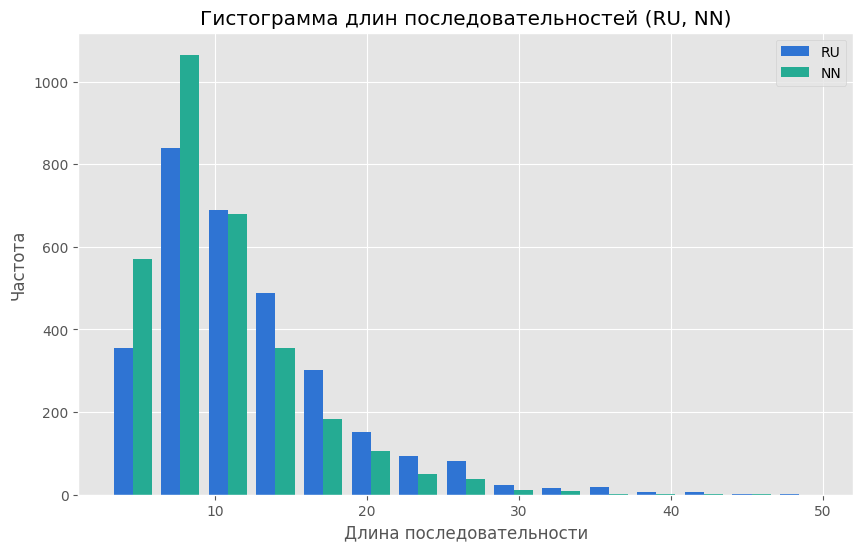

In [ ]:
import matplotlib.pyplot as plt

# Оценка длины последовательностей слов в колонках ru и nn, выводим максимальные длины последовательностей и строим гистограммы длин последовательностей
seq_lens_RU = [len(df['ru'][i].split()) for i in range(len(df))]
seq_lens_NN = [len(df['nn'][i].split()) for i in range(len(df))]

max_len_RU = max(seq_lens_RU)
max_len_NN = max(seq_lens_NN)

print('Максимальная длина предложения (RU):', max_len_RU)
print('Максимальная длина предложения (NN):', max_len_NN)

graph_df = pd.DataFrame()
graph_df['RU'] = seq_lens_RU
graph_df['NN'] = seq_lens_NN

# Настройка стиля графика
plt.style.use('ggplot')

# Создание гистограммы
plt.figure(figsize=(10, 6))
plt.hist([graph_df['RU'], graph_df['NN']], bins=15, label=['RU', 'NN'], color=['#2F74D3', '#25AB93'])

# Добавление подписей к осям и заголовка
plt.xlabel('Длина последовательности')
plt.ylabel('Частота')
plt.title('Гистограмма длин последовательностей (RU, NN)')

# Добавление легенды
plt.legend()

# Вывод графика
plt.show()

### **Токенизация записей**

In [ ]:
from keras.preprocessing.text import Tokenizer

to_exclude = '!"#$%&()*+-:;<=>@[\\]^_`{|}~\t\n'  # символы для удаления

# Инициализация токенизатора
tokenizer_RU = Tokenizer(num_words=-1, filters=to_exclude, oov_token='UNK', lower=True)

# Обучение токенизатора на русских текстах
tokenizer_RU.fit_on_texts(df['ru'])

print("num_words = " + str(tokenizer_RU.num_words))

num_words = -1


In [ ]:
# Анализ редких слов в словаре токенизатора
rare_thresh = 2  # Минимальная частота для того, чтобы слово считалось не редким
cnt = 0  # Число редких слов
tot_cnt = 0  # Общее число слов
freq = 0  # Суммарная частота редких слов
tot_freq = 0  # Общая суммарная частота всех слов

for key, value in tokenizer_RU.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if value < rare_thresh:
        cnt = cnt + 1
        freq = freq + value

print("% редких слов в словаре:", (cnt / tot_cnt) * 100)
print("Общий % редких слов:", (freq / tot_freq) * 100)

# Расчет размера словаря
vocab_size_RU = len(list(tokenizer_RU.word_index)) - cnt + 1  # 1 для токена UNK
print("Количество редких слов " + str(vocab_size_RU))

# Установка размера словаря в токенизаторе
tokenizer_RU.num_words = vocab_size_RU

% редких слов в словаре: 54.29082240762813
Общий % редких слов: 7.284697603752965
Количество редких слов 2303


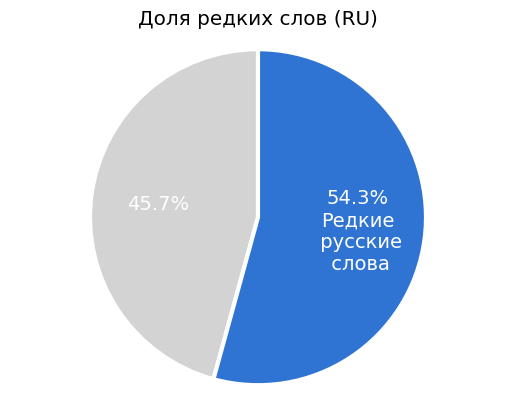

In [ ]:
sizes = [vocab_size_RU, len(tokenizer_RU.word_index) - vocab_size_RU + 1]
colors = ['lightgrey', '#2F74D3']  # Цвета для сегментов

# Функция для форматирования текста
def format_label(pct):
    if pct < 50:
        return f'{pct:.1f}%'
    else:
        return f'{pct:.1f}%\nРедкие\n русские\n слова'

# Построение круговой диаграммы
fig, ax = plt.subplots()
ax.pie(sizes, autopct=format_label, startangle=90, colors=colors, wedgeprops={'edgecolor': 'white', 'linewidth': 3}, labeldistance=0.7)

for text in ax.texts:
    text.set_fontsize(14)
    text.set_color('white')

# Добавляем круговую обводку

plt.axis('equal')  # Равные оси для круговой диаграммы
plt.title('Доля редких слов (RU)')

plt.show()

Процент редких слов в словаре составляет 54%, общий процент редких слов в корпусе около 7%. Количество редких слов в словаре равно 2303. Каждому уникальному слову в корпусе присваивается уникальный индекс в этом словаре.

In [ ]:
tokenizer_RU.word_index

{'UNK': 1,
 'start': 2,
 'end': 3,
 '.': 4,
 ',': 5,
 '—': 6,
 'на': 7,
 'в': 8,
 'говорит': 9,
 'не': 10,
 'старик': 11,
 'и': 12,
 'так': 13,
 'как': 14,
 'с': 15,
 'его': 16,
 'я': 17,
 'к': 18,
 'то': 19,
 'же': 20,
 'у': 21,
 'ты': 22,
 'он': 23,
 '?': 24,
 'по': 25,
 'что': 26,
 'они': 27,
 'ханты': 28,
 'старика': 29,
 'это': 30,
 'опять': 31,
 'когда': 32,
 'за': 33,
 'только': 34,
 'царя': 35,
 'после': 36,
 'из': 37,
 'старуха': 38,
 'царь': 39,
 'пока': 40,
 'того': 41,
 'чум': 42,
 'ее': 43,
 'меня': 44,
 'а': 45,
 'есть': 46,
 'чума': 47,
 'мужчина': 48,
 'все': 49,
 'дочь': 50,
 'сын': 51,
 'со': 52,
 'их': 53,
 'свою': 54,
 'если': 55,
 'она': 56,
 'один': 57,
 'русский': 58,
 'теперь': 59,
 'через': 60,
 'женщина': 61,
 'стал': 62,
 'мышка': 63,
 'будет': 64,
 'домой': 65,
 'мы': 66,
 'тебя': 67,
 'пошел': 68,
 'до': 69,
 'ли': 70,
 'своей': 71,
 'бедный': 72,
 'время': 73,
 'лисичка': 74,
 'тоже': 75,
 'пес': 76,
 'пришел': 77,
 'три': 78,
 'ему': 79,
 'семь': 80,
 'чу

Если слово не входит в токенизатор, ему присваивается индекс 1, который представляет токен "UNK" (неизвестное слово) в токенизаторе.

In [ ]:
sample_text = ["<start> красивый великан на земле <end>",
               "<start> человек паук , человек-паук <end>"]

sample_text_tokenized = tokenizer_RU.texts_to_sequences(sample_text)
print(sample_text_tokenized)

[[2, 1, 104, 7, 133, 3], [2, 155, 1, 5, 155, 1, 3]]


In [ ]:
to_exclude = '!"#$%&()*+-:;<=>@[\\]^_`{|}~\t\n'

tokenizer_NN = Tokenizer(num_words=-1, filters=to_exclude, oov_token='UNK', lower=True)

tokenizer_NN.fit_on_texts(df['nn'])

print("num_words = " + str(tokenizer_NN.num_words))

num_words = -1


In [ ]:
rare_thresh = 2
cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, value in tokenizer_NN.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if value < rare_thresh:
        cnt = cnt + 1
        freq = freq + value

print("% редких слов в словаре:", (cnt / tot_cnt) * 100)
print("Общий % редких слов:", (freq / tot_freq) * 100)

vocab_size_NN = len(list(tokenizer_NN.word_index)) - cnt + 1
print("Количество редких слов " + str(vocab_size_NN))

tokenizer_NN.num_words = vocab_size_NN

% редких слов в словаре: 68.07936293696855
Общий % редких слов: 15.918702265984978
Количество редких слов 2367


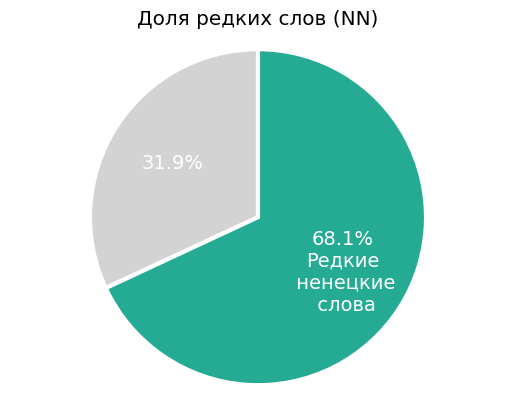

In [ ]:
sizes = [vocab_size_NN, len(tokenizer_NN.word_index) - vocab_size_NN + 1]
colors = ['lightgrey', '#25AB93']

def format_label(pct):
    if pct < 50:
        return f'{pct:.1f}%'
    else:
        return f'{pct:.1f}%\nРедкие\n ненецкие\n слова'

fig, ax = plt.subplots()
ax.pie(sizes, autopct=format_label, startangle=90, colors=colors, wedgeprops={'edgecolor': 'white', 'linewidth': 3}, labeldistance=0.7)

for text in ax.texts:
    text.set_fontsize(14)
    text.set_color('white')

plt.axis('equal')
plt.title('Доля редких слов (NN)')

plt.show()

Процент редких слов в словаре составляет 68%, общий процент редких слов в корпусе около 16%. Количество редких слов в словаре равно 2367.

In [ ]:
tokenizer_NN.word_index

{'UNK': 1,
 'start': 2,
 'end': 3,
 '.': 4,
 ',': 5,
 '—': 6,
 'не': 7,
 'ңани’': 8,
 'вэсако': 9,
 'ма': 10,
 'тарем’': 11,
 'сидя': 12,
 '?': 13,
 'хая': 14,
 'ңоб”': 15,
 'я’': 16,
 'хасава': 17,
 'маси”': 18,
 'ңод”': 19,
 'манзь': 20,
 'ню': 21,
 'вэсако’': 22,
 'ханада': 23,
 'мят’': 24,
 'мань': 25,
 'параңода’': 26,
 'няхар”': 27,
 'ңарка': 28,
 'маңгабада': 29,
 'теда’': 30,
 'ма”нив’': 31,
 'си”ив': 32,
 'сер’': 33,
 'ня’': 34,
 'тад': 35,
 'тикы': 36,
 'нюдя': 37,
 'хаби': 38,
 'луца': 39,
 'вэсакор': 40,
 'ни’': 41,
 'ңамгэ': 42,
 'сава': 43,
 'сюдбя': 44,
 'няна': 45,
 'параңода': 46,
 'пин’': 47,
 'си”ми': 48,
 'ңопой': 49,
 'пыдар': 50,
 'няби': 51,
 'яля’': 52,
 'ни': 53,
 'сит': 54,
 'мяканда': 55,
 'пухуцяда': 56,
 'пухуця': 57,
 'таня': 58,
 'пыда': 59,
 'нянда': 60,
 'ян’': 61,
 'писякор': 62,
 'ңа”': 63,
 'хабей’': 64,
 'поп': 65,
 'да': 66,
 'ңэвы': 67,
 'тюку': 68,
 'тёнякор': 69,
 'хуняна': 70,
 'яха’': 71,
 'тэвы”': 72,
 'та’': 73,
 'яңгу': 74,
 'тэри': 75,
 'н

In [ ]:
sequences_RU = tokenizer_RU.texts_to_sequences(df['ru'])
sequences_NN = tokenizer_NN.texts_to_sequences(df['nn'])

In [ ]:
# Расчет максимальных длин последовательностей для текстов на русском (seq_num_words_RU) и ненецком (seq_num_words_NN) языках
seq_ru_len = []
for i in range(len(sequences_RU)):
  seq_ru_len.append(len(sequences_RU[i]))
seq_num_words_RU = max(seq_ru_len)
print(seq_num_words_RU)

seq_nn_len = []
for i in range(len(sequences_NN)):
  seq_nn_len.append(len(sequences_NN[i]))
seq_num_words_NN = max(seq_nn_len)
print(seq_num_words_NN)

48
42


In [ ]:
# Размер словаря
print(f"Размер словаря для русского: {tokenizer_RU.num_words}")
print(f"Размер словаря для ненецкого: {tokenizer_NN.num_words}")

# Максимальная длина последовательности
print(f"Максимальная длина последовательности для русского: {seq_num_words_RU}")
print(f"Максимальная длина последовательности для ненецкогоа: {seq_num_words_NN}")

Размер словаря для русского: 2303
Размер словаря для ненецкого: 2367
Максимальная длина последовательности для русского: 48
Максимальная длина последовательности для ненецкогоа: 42


In [ ]:
index = 3000
print("Оригинальный текст (RU):", df['ru'][index])
print("Индексная последовательность (RU):", sequences_RU[index])

# Декодирование числовой последовательности обратно в текст
detokenized_RU = tokenizer_RU.sequences_to_texts([sequences_RU[index]])
print("Декодированная последовательность (RU):", detokenized_RU[0])

Оригинальный текст (RU): <start> после этих слов расколол ножом то полено на несколько частей .  <end>
Индексная последовательность (RU): [2, 36, 523, 484, 2301, 1127, 19, 442, 7, 697, 1, 4, 3]
Декодированная последовательность (RU): start после этих слов расколол ножом то полено на несколько UNK . end


In [ ]:
index = 3000
print("Оригинальный текст (NN):", df['nn'][index])
print("Индексная последовательность (NN):", sequences_NN[index])

detokenized_NN = tokenizer_NN.sequences_to_texts([sequences_NN[index]])
print("Декодированная последовательность (NN):", detokenized_NN[0])

Оригинальный текст (NN): <start> тикы вадита пуд пэвдёком’ харахананда сян ян’ лядцада .  <end>
Индексная последовательность (NN): [2, 36, 834, 226, 1389, 1, 391, 61, 1, 4, 3]
Декодированная последовательность (NN): start тикы вадита пуд пэвдёком’ UNK сян ян’ UNK . end


In [ ]:
# Сохранение токенизаторов
import io
import json

tokenizer_json_ru = tokenizer_RU.to_json()
with io.open('/content/tokenizer_RU.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json_ru, ensure_ascii=False))

tokenizer_json_nn = tokenizer_NN.to_json()
with io.open('/content/tokenizer_NN.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json_nn, ensure_ascii=False))

### **Разделение набора данных**

In [ ]:
from sklearn.model_selection import train_test_split
train_RU, test_RU, train_NN, test_NN  = train_test_split(sequences_RU, sequences_NN, test_size=0.2, random_state=42)

### **Реализация простой нейросети**

In [ ]:
from itertools import cycle, islice
from tensorflow.keras.preprocessing.sequence import pad_sequences

def DG(data_RU, data_NN, batch_size, max_text_len_RU, num_words_RU, max_text_len_NN, num_words_NN):
    full_set_size = len(data_RU)
    data_cycle = zip(cycle(data_RU), cycle(data_NN))

    while True:
        batch_data = list(islice(data_cycle, batch_size))

        X_data_in_RU = pad_sequences([item[0] for item in batch_data], maxlen=max_text_len_RU, value=0, padding='post')
        X_data_in_NN = pad_sequences([item[1][:-1] for item in batch_data], maxlen=max_text_len_NN, value=0, padding='post')
        Y_data_NN = pad_sequences([item[1][1:len(item[1])] for item in batch_data], maxlen=max_text_len_NN, value=0, padding='post')

        yield [X_data_in_RU, X_data_in_NN], Y_data_NN

In [ ]:
from keras.layers import Input, Embedding, MultiHeadAttention, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import optimizers
import tensorflow as tf

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ru (InputLayer)       [(None, 48)]                 0         []                            
                                                                                                  
 input_nn (InputLayer)       [(None, 42)]                 0         []                            
                                                                                                  
 embedding_ru (Embedding)    (None, 48, 64)               147392    ['input_ru[0][0]']            
                                                                                                  
 embedding_nn (Embedding)    (None, 42, 64)               151488    ['input_nn[0][0]']            
                                                                                           

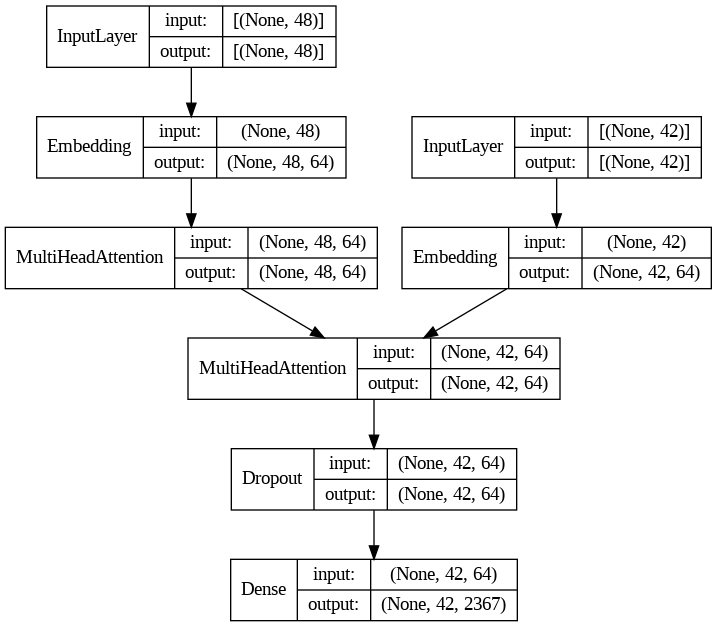

In [ ]:
# Создание нейросети с Keras и слоями MultiHeadAttention

# Входные слои
input_ru = Input(shape=(seq_num_words_RU), name="input_ru")
input_nn = Input(shape=(seq_num_words_NN), name="input_nn")

# Эмбеддинги
embedding_ru = Embedding(tokenizer_RU.num_words, 64, mask_zero=True, name="embedding_ru")
embedding_nn = Embedding(tokenizer_NN.num_words, 64, mask_zero=True, name="embedding_nn")

# Применение эмбеддингов к входным данным
embedded_ru = embedding_ru(input_ru)
embedded_nn = embedding_nn(input_nn)

# Encoder
encoder_ru = MultiHeadAttention(num_heads=2, key_dim=64, name="encoder_ru")
encoder_ru_out = encoder_ru(query=embedded_ru, key=embedded_ru, value=embedded_ru)

# Decoder
decoder_nn = MultiHeadAttention(num_heads=2, key_dim=64, name="decoder_nn")
decoder_outputs = decoder_nn(query=embedded_nn, key=encoder_ru_out, value=encoder_ru_out, use_causal_mask=True)

# Слой Dropout
dropout_layer = Dropout(0.4, name="dropout_layer")
dropout_output = dropout_layer(decoder_outputs)

# Выходной слой
output_layer = Dense(tokenizer_NN.num_words, activation='softmax', name="output_layer")
output = output_layer(dropout_output)

# Создание модели
model = Model([input_ru, input_nn], output)

# Компиляция модели
model.compile(optimizer=optimizers.Adam(lr=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

# Вывод структуры модели и сохранение изображения
model.summary()
plot_model(model, to_file='model_plot.png', expand_nested=True, show_shapes=True, show_layer_names=False)

In [ ]:
import math

#num of vocab and seq len
print(tokenizer_RU.num_words)
print(tokenizer_NN.num_words)
print(seq_num_words_RU)
print(seq_num_words_NN)

batch_size=64
train_DG = DG(data_RU = train_RU, data_NN = train_NN, batch_size = batch_size,
              max_text_len_RU=seq_num_words_RU, num_words_RU=tokenizer_RU.num_words,
              max_text_len_NN=seq_num_words_NN, num_words_NN=tokenizer_NN.num_words)

test_DG = DG(data_RU = test_RU, data_NN = test_NN, batch_size = batch_size,
             max_text_len_RU=seq_num_words_RU, num_words_RU=tokenizer_RU.num_words,
             max_text_len_NN=seq_num_words_NN, num_words_NN=tokenizer_NN.num_words)

nb_train_steps = math.ceil(len(train_RU)/batch_size)
nb_test_steps = math.ceil(len(test_RU)/batch_size)

2303
2367
48
42


Epoch 1/100
39/39 [==============================] - 20s 432ms/step - loss: 6.7346 - accuracy: 0.1635 - val_loss: 5.3826 - val_accuracy: 0.1089
Epoch 2/100
39/39 [==============================] - 16s 417ms/step - loss: 5.3104 - accuracy: 0.1457 - val_loss: 5.2452 - val_accuracy: 0.1810
Epoch 3/100
39/39 [==============================] - 69s 2s/step - loss: 5.2433 - accuracy: 0.1697 - val_loss: 5.2416 - val_accuracy: 0.1812
Epoch 4/100
39/39 [==============================] - 16s 425ms/step - loss: 5.2366 - accuracy: 0.1727 - val_loss: 5.2662 - val_accuracy: 0.1788
Epoch 5/100
39/39 [==============================] - 14s 373ms/step - loss: 5.2034 - accuracy: 0.1748 - val_loss: 5.2472 - val_accuracy: 0.1810
Epoch 6/100
39/39 [==============================] - 19s 481ms/step - loss: 5.1616 - accuracy: 0.1743 - val_loss: 5.2044 - val_accuracy: 0.1811
Epoch 7/100
39/39 [==============================] - 16s 419ms/step - loss: 5.0388 - accuracy: 0.1488 - val_loss: 5.1572 - val_accuracy: 0.

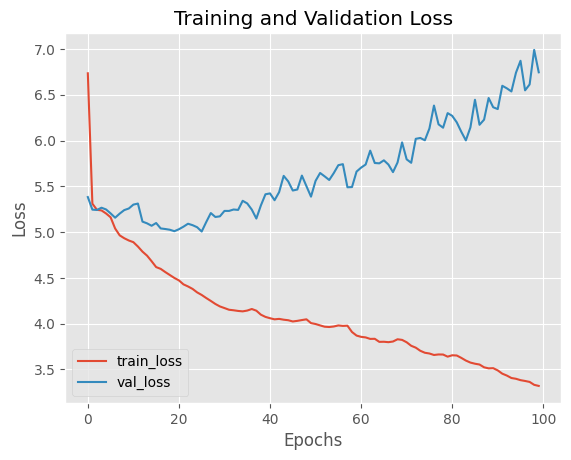

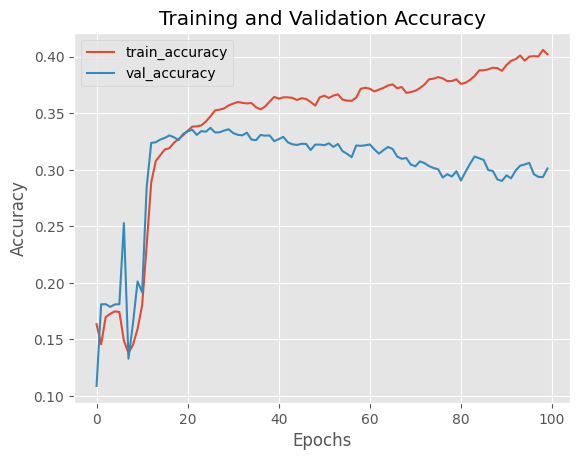

In [ ]:
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from itertools import cycle, islice
from keras.callbacks import EarlyStopping

callbacks = [ModelCheckpoint('/content/сheckpoints', monitor='val_loss', save_best_only=True, verbose=0)]

history = model.fit(train_DG,
                    validation_data=test_DG,
                    validation_steps=nb_test_steps,
                    steps_per_epoch=nb_train_steps,
                    epochs=100,
                    callbacks=callbacks,
                    shuffle=True)

# График для функции потерь
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График для метрики (например, accuracy)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
to_tokenize = '.,:!?\'"'
sample_text = 'лесное чудище осталось ни с чем .' #вечером они легли спать

sample_text = re.sub(r'([' + to_tokenize + '])', r' \1 ', sample_text)
sample_text = marker1 + " " + sample_text + " " + marker2
print(sample_text)

sample_tokenized = pad_sequences(tokenizer_RU.texts_to_sequences([sample_text]), maxlen=seq_num_words_RU, value=0, padding='post')
print(sample_tokenized)

encoder_model = Model(input_ru, encoder_ru_out)

decoder_k_v = Input(shape=(seq_num_words_RU, 64,))
decoder_outputs_pred = decoder_nn(query=embedded_nn, key=decoder_k_v, value=decoder_k_v, use_causal_mask=True)
decoder_outputs_fin = output_layer(decoder_outputs_pred)
decoder_model = Model([input_nn, decoder_k_v], [decoder_outputs_fin])

start_word = [[2]]
predicted_tokenized = [[2]]

encoded_msg = encoder_model.predict(sample_tokenized)
input_symbol_seq = start_word.copy()
deoder_states_in = encoded_msg.copy()

for i in range(seq_num_words_NN - 1):
    if predicted_tokenized[0][-1] == 3:
        break

    predicted_tokenized_processed = pad_sequences(input_symbol_seq, maxlen=seq_num_words_NN, value=0, padding='post')

    decoded_msg = decoder_model.predict([predicted_tokenized_processed, deoder_states_in])

    predicted_token_num = np.argmax(decoded_msg[0][i])

    predicted_tokenized[0].append(predicted_token_num)
    input_symbol_seq[0].append(predicted_token_num)

detokenized_NN = tokenizer_NN.sequences_to_texts(predicted_tokenized)
print(detokenized_NN)

<start> лесное чудище осталось ни с чем  .  <end>
[[  2 338  81 849 134  15 721   4   3   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
1/1 [==============================] - 0s 52ms/step
['start пэдара’ ңылекар ядэрңа . end']


In [ ]:
# Сохранение модели
model.save("NML_model.h5")